# Chapter 3 : Classification
Pada chapter 3 ini mempelajari tentang supervised learning untuk sistem classification.

## Dataset MNIST
Pada chapter ini, dataset yang digunakan adalah MNIST, yang merupakan satu set dari 70.000 gambar kecil digit yang ditulis tangan oleh siswa sekolah menengah dan karyawan Biro Sensus AS. Setiap gambar diberi label dengan digit yang diwakilinya. Kumpulan data ini telah dipelajari sedemikian rupa sehingga sering disebut "hello world" dari Pembelajaran Mesin (Machine Learning).

In [1]:
# Impor library dan unduh dataset MNIST
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

Kunci dataset MNIST: dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
Shape X: (70000, 784)
Shape y: (70000,)


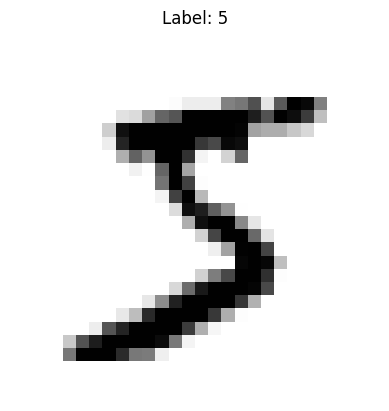

In [ ]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
print("Kunci dataset MNIST:", mnist.keys())

X, y = mnist["data"], mnist["target"]

print("Shape X:", X.shape) 
print("Shape y:", y.shape) 

y = y.astype(np.uint8)

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.title(f"Label: {y[0]}")
plt.show()

### Membagi data untuk training dan testing
Karena dataset MNIST ada 70.000 gambar, kita bagi dataset menjadi 60.000 untuk training dan 10.000 untuk testing.

In [3]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print(f"Ukuran data training: {len(X_train)}")
print(f"Ukuran data testing: {len(X_test)}")

Ukuran data training: 60000
Ukuran data testing: 10000


## Training a Binary Classifier
Mencoba menyederhanakan masalah dengan mengidentifikasi hanya satu angka, misalnya 5. Ini akan menjadi contoh pengklasifikasian biner, yang mampu membedakan antara 5 dan bukan 5. Klasifikasi ini menggunakan SGDClassifier, dimana klasifikasi ini memiliki keunggulan dalam menangani dataset yang besar secara efisien

In [ ]:
from sklearn.linear_model import SGDClassifier

y_train_5 = (y_train == 5) 
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

prediksi = sgd_clf.predict([some_digit])
print(f"Prediksi untuk gambar pertama: {prediksi}")

Prediksi untuk gambar pertama: [ True]


## Evaluasi Performa Klasifikasi
Evaluasi sistem klasifikasi seringkali jauh lebih rumit dibandingkan evaluasi sistem regresi. Ada banyak parameter performa untuk evaluasi sistem klasifikasi.

### Mengukur Akurasi Menggunakan Cross-Validation
Disini menggunakan fungsi cross_val_score() untuk mengevaluasi model SGDClassifier. K fold cross-validation berarti membagi set data pelatihan menjadi K fold, lalu membuat prediksi dan mengevaluasinya pada setiap fold menggunakan model yang dilatih pada fold yang tersisa.

In [9]:
from sklearn.model_selection import cross_val_score

akurasi_cv = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(f"Akurasi SGDClassifier (cross-validation 3-fold): {akurasi_cv}")
print(f"Rata-rata akurasi: {akurasi_cv.mean():.4f}")

Akurasi SGDClassifier (cross-validation 3-fold): [0.95035 0.96035 0.9604 ]
Rata-rata akurasi: 0.9570


Akurasi yang didapat diatas 93%. Namun kita lihat klasifikasi yang hanya mengklasifikasikan setiap gambar ke dalam kelas 'bukan 5'.

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) # Selalu prediksi False (bukan 5)

never_5_clf = Never5Classifier()
akurasi_never5 = cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(f"Akurasi Never5Classifier: {akurasi_never5}")
print(f"Rata-rata akurasi 'bodoh': {akurasi_never5.mean():.4f}")

Akurasi Never5Classifier: [0.91125 0.90855 0.90915]
Rata-rata akurasi 'bodoh': 0.9096


Akurasi yang didapat lebih dari 90%. Hal ini terjadi karena hanya sekitar 10% dari gambar yang merupakan 5, jadi jika menebak bahwa sebuah gambar bukan 5, akan benar 90%. Ini menunjukkan mengapa akurasi umumnya bukan ukuran kinerja yang disukai untuk klasifikasi, terutama saat Anda bekerja dengan dataset yang tidak seimbang. 

### Confusion Matrix
Cara yang jauh lebih baik untuk mengevaluasi kinerja klasifikasi adalah dengan melihat confusion matrix. Ide dasarnya adalah menghitung berapa kali contoh dari kelas A diklasifikasikan sebagai kelas B. Misalnya, untuk mengetahui berapa kali klasifikasi salah mengidentifikasi gambar angka 5 dengan angka 3, kita perlu melihat baris kelima dan kolom ketiga pada
confusion matrix. Untuk menghitung confusion matrix, kita terlebih dahulu perlu memiliki kumpulan prediksi sehingga mereka dapat dibandingkan dengan target sebenarnya.



In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix


y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cm = confusion_matrix(y_train_5, y_train_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[53892   687]
 [ 1891  3530]]


Setiap baris dalam confusion matrix mewakili kelas aktual, sementara setiap kolom mewakili kelas yang diprediksi. Sebuah klasifikasi yang sempurna hanya akan memiliki positif sejati dan negatif sejati, sehingga confusion matrix hanya akan memiliki nilai non-nol pada diagonal utamanya (dari kiri atas ke kanan bawah). Cara sederhana untuk mendapatkan presisi sempurna adalah dengan membuat satu prediksi positif tunggal dan memastikan prediksi tersebut benar (presisi = 1/1 = 100%). Namun, hal ini tidak akan terlalu berguna, karena klasifikasi akan mengabaikan semua contoh positif kecuali satu. Oleh karena itu, presisi biasanya digunakan bersama dengan metrik lain yang disebut recall, juga dikenal sebagai sensitivitas atau tingkat positif benar.

### Precision and Recall

In [14]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)

print(f"Precision: {precision:.4f}") 
print(f"Recall: {recall:.4f}")    

Precision: 0.8371
Recall: 0.6512


Ketika detektor menyatakan bahwa suatu gambar mewakili angka 5, hal itu benar hanya 83,7%. Selain itu, detektor ini hanya mendeteksi 65,1% dari angka 5. Seringkali lebih praktis untuk menggabungkan presisi dan recall menjadi satu metrik yang disebut skor F1 score, terutama jika Anda membutuhkan cara sederhana untuk membandingkan dua klasifikasi. Skor F1 adalah
rata-rata harmonik dari presisi dan recall. Sementara rata-rata biasa menganggap semua nilai sama, rata-rata harmonik memberikan bobot yang jauh lebih besar pada nilai rendah. Akibatnya, klasifikasi hanya akan mendapatkan skor F1 yang tinggi jika baik recall maupun presisi juga tinggi.

In [15]:
from sklearn.metrics import f1_score

f1 = f1_score(y_train_5, y_train_pred)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.7325


Skor F1 mengutamakan klasifikasi yang memiliki presisi dan recall yang serupa. Hal ini tidak selalu sesuai dengan yang Anda inginkan: dalam beberapa konteks, Anda lebih mementingkan presisi, dan dalam konteks lain Anda benar-benar mementingkan recall. Misalnya, jika Anda melatih klasifikasi untuk mendeteksi video yang aman untuk anak-anak, Anda mungkin lebih memilih klasifikasi yang menolak banyak video yang baik (recall rendah) tetapi hanya menyimpan yang aman (presisi tinggi), daripada klasifikasi yang memiliki recall jauh lebih tinggi tetapi membiarkan beberapa video buruk muncul di produk Anda (dalam kasus seperti ini, Anda mungkin ingin menambahkan proses manual untuk memeriksa pemilihan video oleh klasifikasi). Di sisi lain, misalkan Anda melatih klasifikasi untuk mendeteksi pencuri di gambar pengawasan: mungkin tidak masalah jika klasifikasi Anda hanya memiliki 30% presisi asalkan memiliki 99% recall (tentu saja, petugas keamanan akan mendapatkan beberapa peringatan palsu, tetapi hampir semua pencuri akan tertangkap).

### Precision/Recall Trade-of
Untuk memahami trade-off, kita harus melihat bagaimana SGDClassifier membuat keputusan klasifikasinya. Untuk setiap instance, ia menghitung skor berdasarkan fungsi keputusan. Jika skor tersebut lebih besar dari ambang batas, instance tersebut diklasifikasikan ke dalam kelas positif; jika tidak, instance tersebut diklasifikasikan ke dalam kelas negatif.  Misalkan ambang batas keputusan ditempatkan pada panah tengah (antara dua angka 5): Anda akan menemukan 4 positif benar (angka 5 yang sebenarnya) di sebelah kanan ambang batas tersebut, dan 1 positif palsu (sebenarnya angka 6). Oleh karena itu, dengan ambang batas tersebut, presisi adalah 80% (4 dari 5). Namun, dari 6 angka 5 yang sebenarnya, klasifikasi hanya mendeteksi 4, sehingga recall adalah 67% (4 dari 6). Jika Anda menaikkan ambang batas (memindahkannya ke panah di sebelah kanan), false positive (angka 6) menjadi true negative, sehingga meningkatkan presisi (hingga 100% dalam kasus ini), tetapi satu true positive menjadi false negative, menurunkan recall menjadi 50%. Sebaliknya, menurunkan ambang batas meningkatkan recall dan mengurangi presisi.

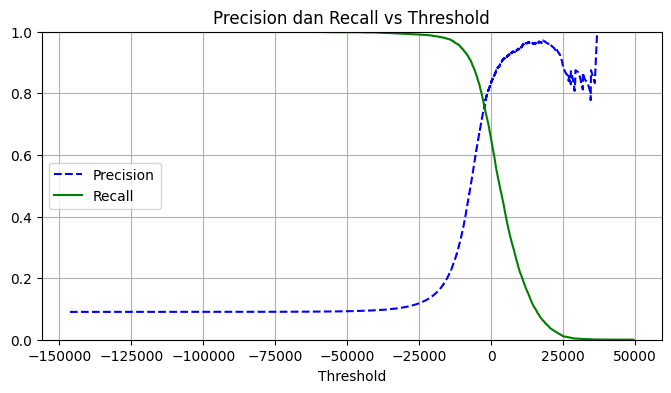

In [16]:
from sklearn.metrics import precision_recall_curve

# Dapatkan decision scores alih-alih prediksi
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# Hitung precision, recall untuk berbagai threshold
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Plot kurva
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title("Precision dan Recall vs Threshold")
plt.show()

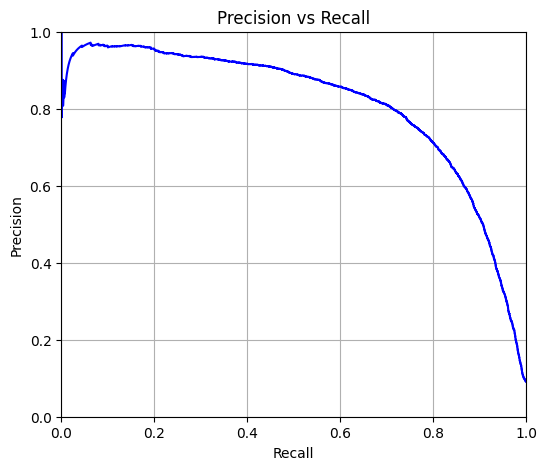

In [17]:
# Plot Precision vs Recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], "b-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(6, 5))
plot_precision_vs_recall(precisions, recalls)
plt.title("Precision vs Recall")
plt.show()

### Receiver Operating Characteristic (ROC) Curve
Kurva ROC adalah tools lain yang digunakan dengan klasifikasi biner. Kurva ini sangat mirip dengan kurva presisi/recall, tetapi alih-alih menggambar presisi versus recall, kurva ROC menggambar tingkat positif benar (nama lain untuk recall) terhadap tingkat positif palsu (FPR). FPR adalah rasio contoh negatif yang salah diklasifikasikan sebagai positif. Nilainya sama dengan 1 – tingkat negatif benar (TNR), yang merupakan rasio dari contoh negatif yang diklasifikasikan dengan benar sebagai negatif. TNR juga disebut spesifisitas. Oleh karena itu, kurva ROC menggambarkan sensitivitas (recall) versus 1 – spesifisitas.

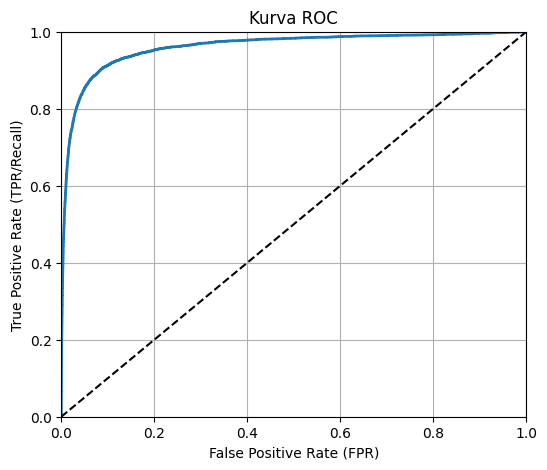

Area Under Curve (AUC): 0.9605


In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Garis diagonal (acak)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR/Recall)')
    plt.grid(True)

plt.figure(figsize=(6, 5))
plot_roc_curve(fpr, tpr, "SGD")
plt.title("Kurva ROC")
plt.show()

# Hitung AUC
auc = roc_auc_score(y_train_5, y_scores)
print(f"Area Under Curve (AUC): {auc:.4f}")

## Multiclass Classification
Jika binary classifier digunakan untuk membedakan dua kelas, multiclass classification dapat membedakan antara lebih dari dua kelas. Beberapa algoritma (seperti klasifikasi SGD, klasifikasi Hutan Acak, dan klasifikasi Naive Bayes) mampu menangani kelas-kelas multiple secara native. Yang lain (seperti Regresi Logistik atau klasifikasi Mesin Vektor Dukungan) adalah klasifikasi biner murni. Namun, ada berbagai strategi yang dapat Anda gunakan untuk melakukan klasifikasi multikelas
dengan menggunakan beberapa klasifikasi biner. Salah satu cara untuk membuat sistem yang dapat mengklasifikasikan gambar angka ke dalam 10 kelas (dari 0 hingga 9) adalah dengan melatih 10 klasifikasi biner, masing-masing untuk setiap angka (seperti detektor 0, detektor 1, detektor 2, dan seterusnya). Kemudian, saat ingin mengklasifikasikan gambar, Anda mendapatkan skor keputusan dari setiap klasifikasi untuk gambar tersebut dan memilih kelas yang klasifikasinya menghasilkan skor tertinggi. Ini disebut strategi one-versus-the-rest (OvR) (juga disebut one-versus-all). Strategi lain adalah melatih klasifikasi biner untuk setiap pasangan digit: satu untuk membedakan 0 dan 1, satu lagi untuk membedakan 0 dan 2, satu lagi untuk 1 dan 2, dan seterusnya. Ini disebut strategi one-versus-one (OvO). Jika ada N kelas, Anda perlu
melatih N × (N – 1) / 2 klasifikasi. 

In [19]:
sgd_clf.fit(X_train, y_train) # Gunakan y_train asli (0-9), bukan y_train_5

prediksi_multikelas = sgd_clf.predict([some_digit])
print(f"Prediksi SGD untuk gambar pertama (seharusnya 5): {prediksi_multikelas}")

# Melihat skor untuk setiap kelas
some_digit_scores = sgd_clf.decision_function([some_digit])
print("\nSkor untuk setiap kelas:")
print(np.round(some_digit_scores, 2))
print(f"Kelas dengan skor tertinggi: {np.argmax(some_digit_scores)}")

Prediksi SGD untuk gambar pertama (seharusnya 5): [3]

Skor untuk setiap kelas:
[[-31893.03 -34419.69  -9530.64   1823.73 -22320.15  -1385.8  -26188.91
  -16147.51  -4604.35 -12050.77]]
Kelas dengan skor tertinggi: 3


## Error Analysis
Jika pada proyek nyata, anda akan menjelajahi opsi persiapan data, mencoba beberapa model (memilih yang terbaik dan menyesuaikan hiperparameternya menggunakan GridSearchCV), dan mengotomatisasi sebanyak mungkin. Anggap bahwa anda telah menemukan model yang menjanjikan dan ingin mencari cara untuk memperbaikinya. Salah satu cara
untuk melakukannya adalah dengan menganalisis jenis kesalahan yang dibuatnya.

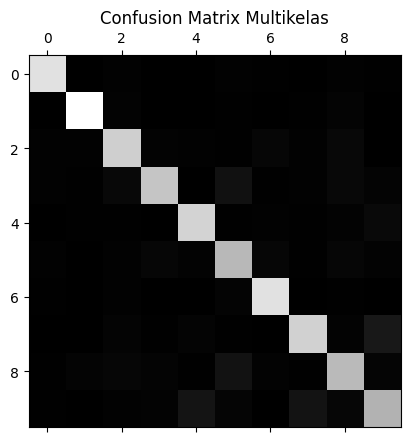

In [21]:
# Dapatkan prediksi multikelas menggunakan cross-validation
y_train_pred_multi = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

# Hitung confusion matrix
conf_mx_multi = confusion_matrix(y_train, y_train_pred_multi)

# Visualisasikan confusion matrix
plt.matshow(conf_mx_multi, cmap=plt.cm.gray)
plt.title("Confusion Matrix Multikelas")
plt.show()



Confusion Matrix ini terlihat cukup baik, karena sebagian besar gambar berada di diagonal utama, yang berarti mereka diklasifikasikan dengan benar. Angka 5 terlihat sedikit lebih gelap daripada angka lainnya, yang bisa berarti ada lebih sedikit gambar angka 5 dalam dataset atau klasifikator tidak bekerja sebaik pada angka 5 dibandingkan angka lainnya. Faktanya, Anda dapat memverifikasi bahwa kedua hal tersebut benar. Mari fokus pada kesalahan. Pertama, anda perlu membagi setiap nilai dalam confusion matrix dengan jumlah gambar dalam kelas yang bersangkutan sehingga Anda dapat membandingkan tingkat kesalahan daripada jumlah kesalahan absolut.

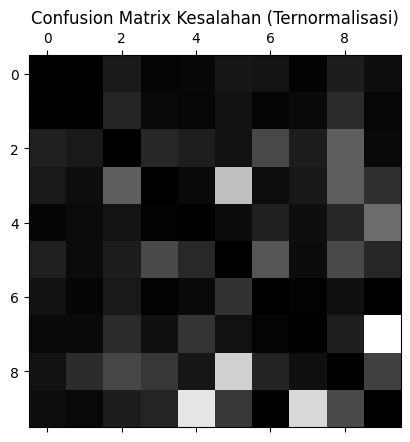

In [22]:
# Fokus pada kesalahan: bagi setiap nilai dengan jumlah gambar di kelas aktual
# dan isi diagonal utama (prediksi benar) dengan nol
row_sums = conf_mx_multi.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx_multi / row_sums
np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.title("Confusion Matrix Kesalahan (Ternormalisasi)")
plt.show()

Anda dapat dengan jelas melihat jenis kesalahan yang dibuat oleh klasifikasi. Ingatlah bahwa baris mewakili kelas sebenarnya, sementara kolom mewakili kelas yang diprediksi. Kolom untuk kelas 8 cukup terang, yang menunjukkan bahwa banyak gambar salah diklasifikasikan sebagai 8. Namun, baris untuk kelas 8 tidak terlalu buruk, menunjukkan bahwa gambar sebenarnya yang termasuk kelas 8 umumnya diklasifikasikan dengan benar sebagai 8. Seperti yang dapat Anda lihat, matriks kebingungan tidak selalu simetris.

## Multilabel Classification
Sampai saat ini, setiap instance selalu dihubungkan dengan hanya satu kelas. Dalam beberapa kasus, anda
mungkin ingin klasifikasi anda menghasilkan beberapa kelas untuk setiap instance. 

In [23]:
from sklearn.neighbors import KNeighborsClassifier

# Contoh: Buat dua label untuk setiap digit
# Label 1: Apakah digit >= 7?
# Label 2: Apakah digit ganjil?
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

# Latih KNeighborsClassifier (mendukung multilabel)
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

# Prediksi untuk gambar pertama (angka 5)
prediksi_multilabel = knn_clf.predict([some_digit])
print(f"Prediksi multilabel untuk angka 5: {prediksi_multilabel}")
print("(Benar: [False, True] -> tidak besar, ganjil)")

Prediksi multilabel untuk angka 5: [[False  True]]
(Benar: [False, True] -> tidak besar, ganjil)


## Multioutput Classification
Jenis classification task yang terakhir adalah multioutput-multiclass classification. Ini hanyalah generalisasi
dari klasifikasi multilabel di mana setiap label dapat berupa multiclass (yaitu, dapat memiliki lebih dari dua nilai yang mungkin).

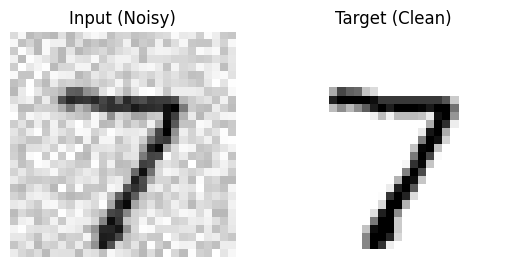

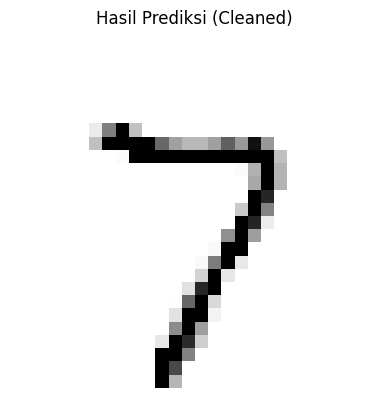

In [ ]:
noise_train = np.random.randint(0, 100, (len(X_train), 784))
noise_test = np.random.randint(0, 100, (len(X_test), 784))
X_train_mod = X_train + noise_train
X_test_mod = X_test + noise_test
y_train_mod = X_train 
y_test_mod = X_test

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.title("Input (Noisy)")
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.title("Target (Clean)")
plt.show()

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])

plt.figure()
plot_digit(clean_digit)
plt.title("Hasil Prediksi (Cleaned)")
plt.show()


# Exercise

## 1.Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).